In [ ]:
%load_ext memory_profiler

import nest_asyncio
nest_asyncio.apply()

# Асинхронное исполнение в Python: как, почему и зачем?

*Содержание*
1. Вспомнинаем концепции.
    1. [Subroutine и Coroutine](#subroutine_coroutine)
    2. [Concurrency и Parallelism](#concurrency_parallelism)
    3. [Synchronous и Asynchronous](#synchronous_asynchronous)
    4. [Preemptive multitasking и Cooperative multitasking](#preemptive_cooperative)
2. [Быстрый взгляд на устройство многопоточности внутри Python процесса.](#python_process)
    1. [GIL](#gil)
3. [Генераторы как недо-корутины.](#generators)
4. [Полноценная поддержка асинхронности на уровне языка.](#asyncawait)
5. [Asyncio: что такое event loop.](#eventloop)
6. [Asyncio vs multithreading](#asyncio_multithreading)
7. [Case-study: asynchronous crawler with aiohttp](#crawler)
8. [Conclusion: asyncio use cases and benefits](#asyncio_use_cases)

Асинхронное исполнение в приложениях - это способность работать с некоторым потоком случайно происходящих событий (сигналов, сетевых пакетов, сообщений и тд.) или неупорядоченных путей исполнения хода программы (многопоточности некоторых операций) без явного прерывания исполнения приложения для ожидания результатов. В ходе этого рассказа разберем какие инструменты для этого предоставляют современные версии Python и для каких практических задач они обычно применяются.

## 1. Вспоминаем концепции

### Subroutine and Coroutine<a name="subroutine_coroutine"></a>

*Subroutine* - одно из самых базовых понятий в программировании, буквально - последовательность инструкций, выполняющих
определенную функцию и объединенных в некоторую единицу исполнения. Имеют одну точку входа и одну точку выхода.
<img src="https://sun9-49.userapi.com/c853420/v853420062/173b94/m2WXh4LvpEo.jpg" width="400" height="600"/>

*Coroutine* - генерализация сабрутин, также объединенная в единицу исполнения последовательность инструкций, но способная приостанавливать выполнение в определенных точках и передавать контроль над исполнением другим корутинам/другому треду. Точно так же имеют одну точку входа, а также сколько угодно точек повторного входа, а затем опционально одну точку выхода.
<img src="https://sun9-70.userapi.com/c853420/v853420062/173b8c/epgTkNSQq6M.jpg" width="400" height="600"/>
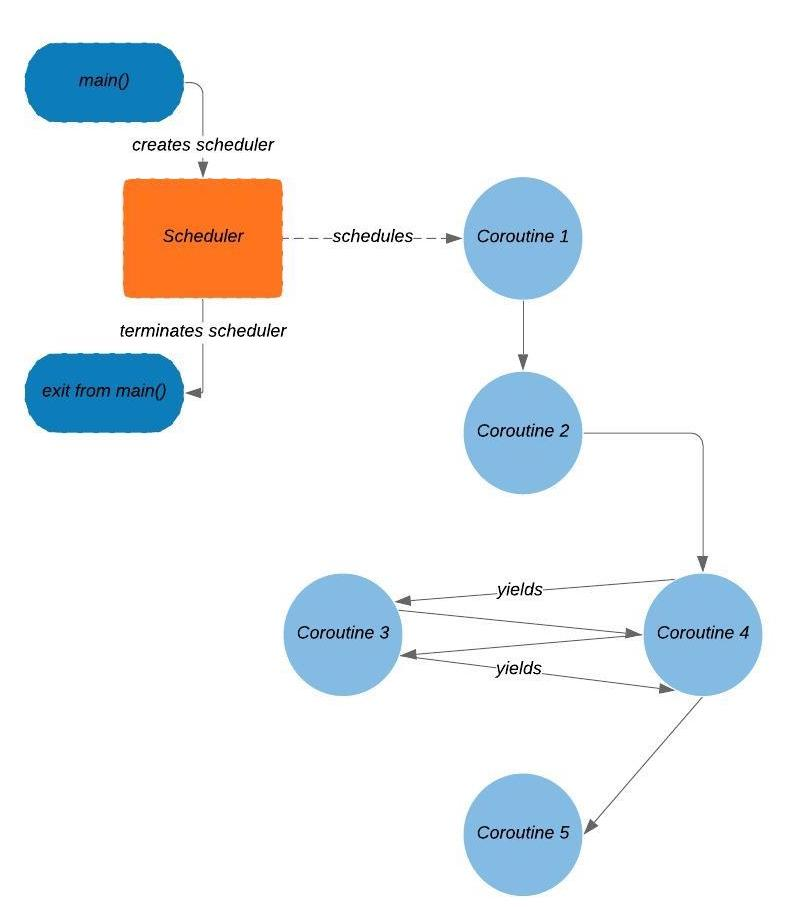
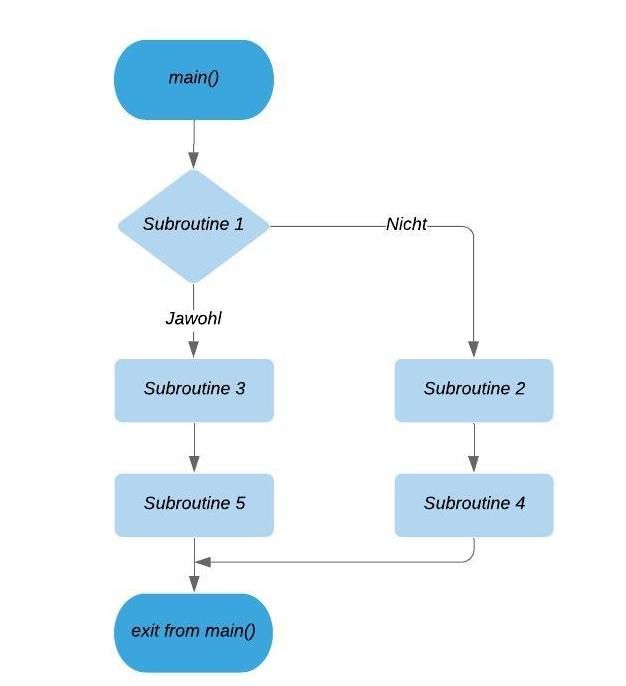

### Concurrency and Parallelism<a name="concurrency_parallelism"></a>



*Concurrency* - конкурентность означает, что процесс выполнения нескольких вычислений может происходить без строгой последовательности, пересекаясь во временном диапазоне выполнения, но при этом приводя к одинаковому результату.

*Parallelism* - выполнение вычислений происходит независимо друг от друга.

Конкурентность и паралеллизм реализуются в виде двух наиболее распространенных моделей: совместно используемой памяти (два процесса на одном компьютере, разделяющих общую область оперативной памяти, два процесса оперирующих над общей файловой системой, два треда в одном процессе, оперирующих над общими объектами находящимися в области памяти процесса) и обмена сообщениями, когда два компонента модели обмениваются сообщениями по какому-то коммуникационному каналу (например, по сети или как два процесса на одном компьютере с соединенными std.in и std.out).

Конкурентность без параллелизма - это многозадачное исполнение на одном процессоре, когда в перемежающихся промежутках времени различные компоненты модели вычислений получают процессорное время.

<img src="https://sun9-66.userapi.com/c853420/v853420062/173b56/4LhWMgn75a8.jpg" width="600" height="500"/>
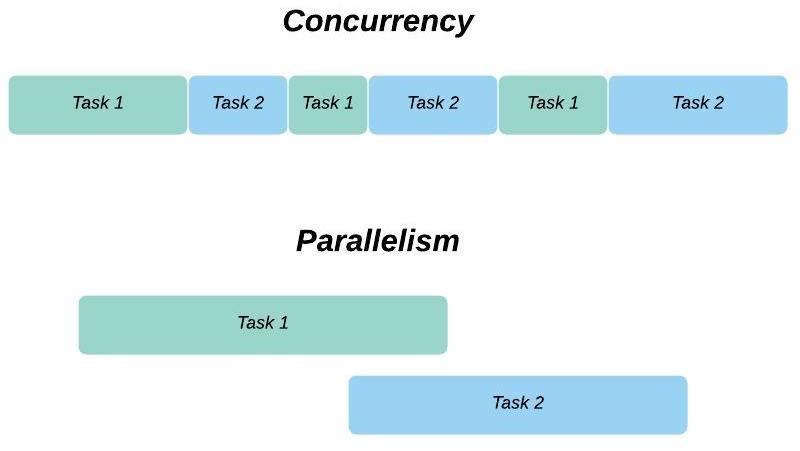

### Synchronous and Asynchronous<a name="synchronous_asynchronous"></a>

*Synchronous*  - синхронное выполнение вычислений означает, что каждая последущая подзадача должна дождаться конца выполнения предыдущей, выполнение происходит в порядке строгой очереди.

*Asynchronous* - асинхронное выполнение задач может начинаться и заканчиваться в любой момент времени и не дает никакой гарантии порядка  выполнения.

<img src="https://sun9-69.userapi.com/c853420/v853420062/173b83/IdIEJ0CFnvA.jpg" width="700" height="500"/>
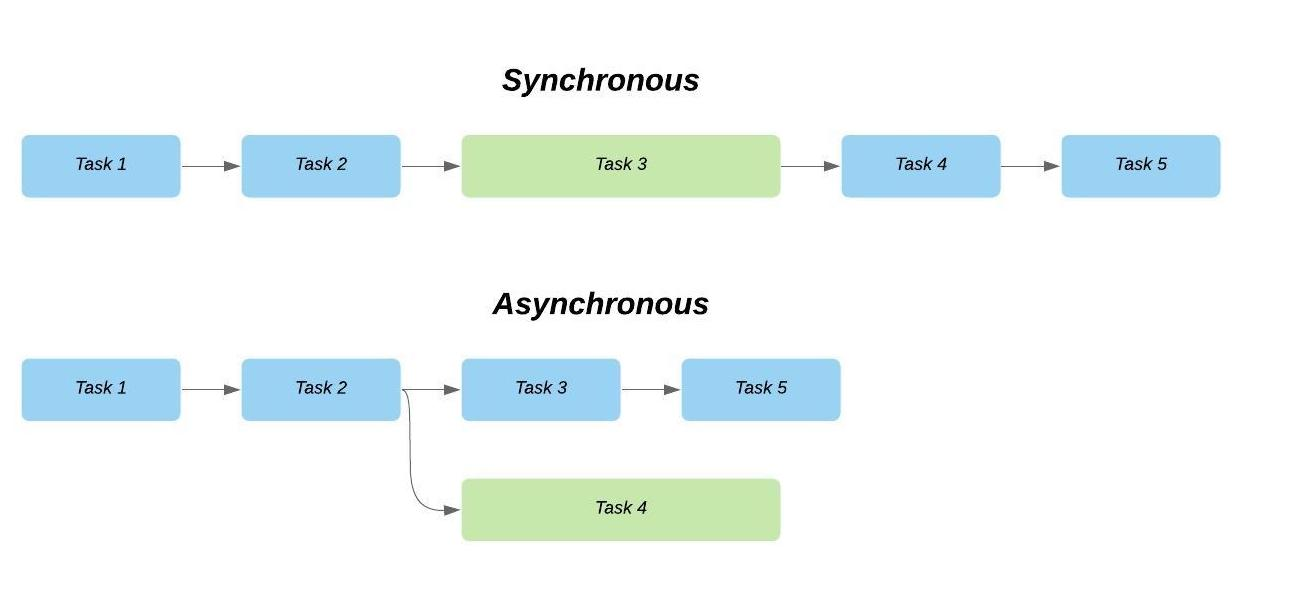

### Preemptive multitasking and Cooperative multitasking<a name="preemptive_cooperative"></a>

*Preemptive* - При вытесняющей многозадачности потоки исполнения программы/задачи контролируются планировщиком (например, на уровне процесса или на уровне ОС) и процессорное время получают потоки с максимальными приоритетами, которые назначаются исходя из типа задачи, выполняемой потоком или времени необходимого на выполнение. Исполнение потока прерывается в любой момент времени по решению планировщика.

*Cooperative* - В кооперативной многозадачности потоки исполнения не прерываются извне и переключения контекста по решению планировщика никогда не происходит. Планировщик только инициирует поток, который затем добровольно отдает контроль обратно планировщику в случае ожидания или логического блока.

<img src="https://sun9-43.userapi.com/c853420/v853420062/173b70/mNwFd2so2Ew.jpg" width="500" height="700">
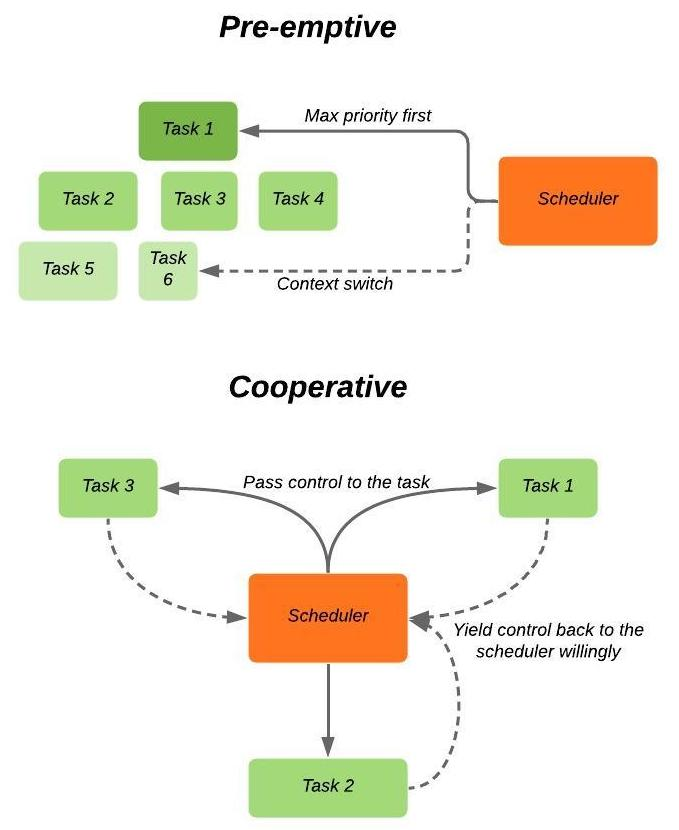

#### Takeaway:

* Сабрутины - не конкурентны, параллелятся, если запустить на разных процессорах/в разных тредах
* Корутины - конкурентны, обычно не параллелятся

## 2. Быстрый взгляд на устройство многопоточности внутри Python процесса<a name="python_process"></a>

<img src="https://sun9-49.userapi.com/c853420/v853420062/173b79/9zpXgV-DpZM.jpg"/>
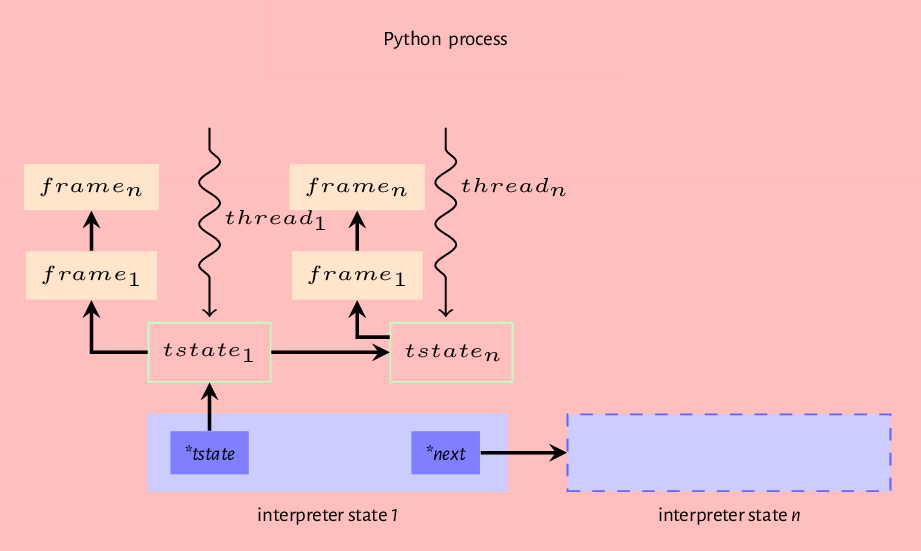

В Python все устроено следующим образом. Как мы можем помнить, в одном процессе может находиться только один Python-интерпретатор. Этот процесс может состоять из нескольких тредов, где каждый тред - это стек-образная структура, состоящая из фреймов, где каждый фрейм - это объект (CodeObject), соответствующий вызову некоторой сабрутины, которая пока не вернула значение и тем самым не завершила работу. 

Треды - это реальные треды операционной системы и у интерпретатора нет механизмов для управления ими в виде приоритетов, вытесняющей многозадачности, round-robin и т.п. Эта функция целиком возлагается на операционную систему. Это одна из причин странной работы сигналов: интерпретатор никак не может контролировать запуск потоков, он просто переключает их как можно чаще, надеясь, что запустится главный поток.

### GIL
При этом при работе с тредами нужно обязательно помнить, что существует глобальный лок интерпретатора (GIL) не дающий более чем одному треду выполняться одновременно и гарантирующий треду, захватившему лок, эксклюзивный доступ к переменным интерпретатора. Потоки удерживают GIL, пока выполняются. Однако они освобождают его при блокировании для операций ввода-вывода (read, write, send, recv). Каждый раз, когда поток вынужден ждать, другие, готовые к выполнению, потоки используют свой шанс запуститься. 

<img src="https://sun9-43.userapi.com/c853420/v853420062/173b67/MMFJ0zGI47w.jpg" height="800" width="800"/>
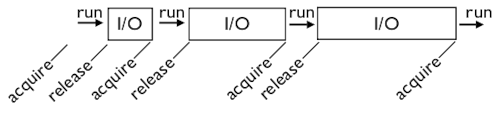

При работе с CPU-зависимыми потоками, которые никогда не производят операции ввода-вывода, интерпретатор приостанавливает треды с явным таймаутом, по истечению которого тред сигнализирует о том, что хочет захватить лок, чтобы продолжить выполнение.

<img src="https://sun9-51.userapi.com/c853420/v853420062/173b60/bMZMY8ji0-0.jpg" height="600" width="900"/>
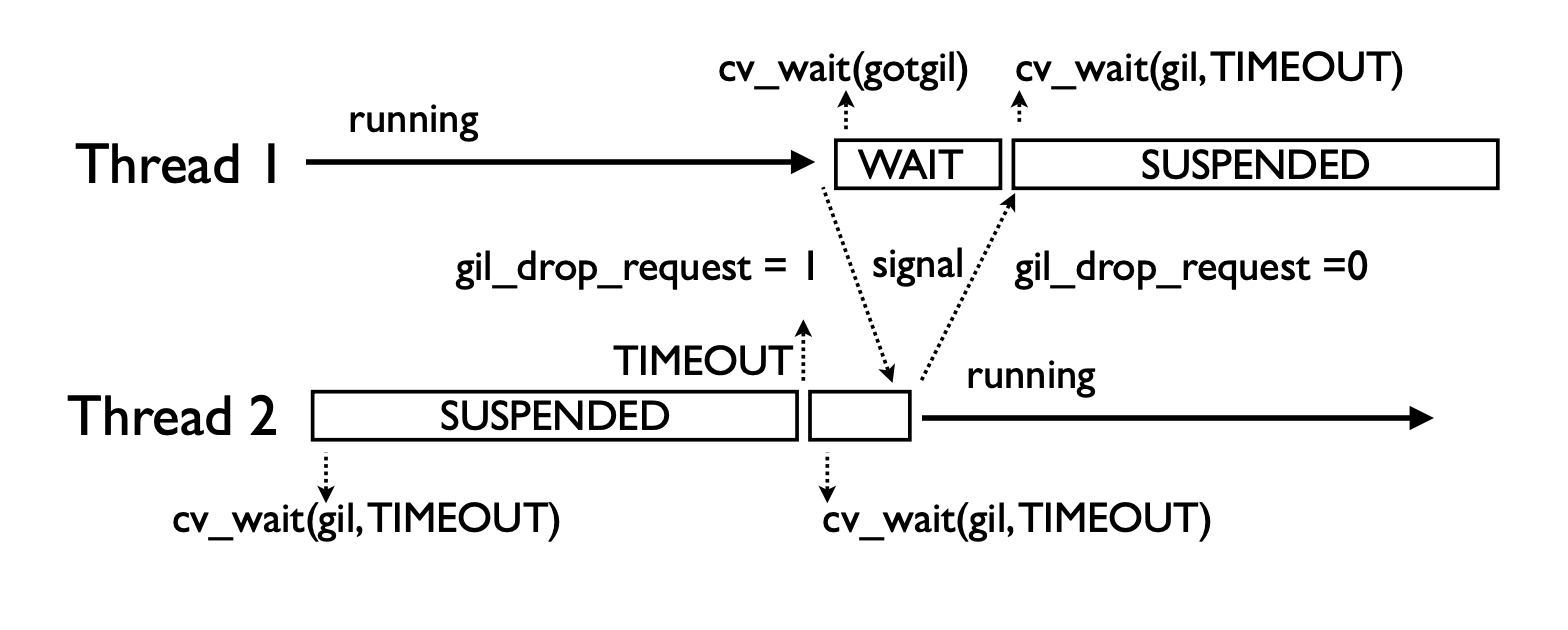

1. Thread 1 выполняется, Thread 2 находится в ожидании GIL с таймаутом TIMEOUT
2. По истечению Thread 2 просыпается, выставляет флаг gil_drop и снова засыпает
3. Thread 1 прекращает работу и отсылает Thread 2 сигнал о статусе захвата GIL и засыпает до получения ответа
4. Thread 2 получает сигнал от Thread 1, отправляет сигнал об успешном захвате и начинает работу
5. Thread 1 получает ответ от Thread 2, убирает флаг gil_drop и засыпает на TIMEOUT

Это все, что нам нужно знать для того, чтобы понимать поверх каких базовых механизмов будут реализованы асинхронные операции.

## 3. Генераторы как недо-корутины

Ранними реализациями корутин в питоне стали генераторы, получившие еще в Python 2.5 синтаксис `send()`, `throw()`, `close()` позволяющий передавать значение в инициализированный генератор и управлять им извне.

Сам генератор не является полноценной корутиной, поскольку только отдает значение (или получает) через `yield` вызвавшему его объекту, и не передает контроль над исполнением другой корутине, а просто возвращает контроль над исполнением вызвавшему объекту.

In [ ]:
class DemoException(Exception):
    pass

def generator():
    print('-> generator started')
    while True:
        try:
            x = yield  # Порождает следующее значение, выполнение прерывается, как только доходит до yield.
        except DemoException:
            print('-> DemoException handled.')
        else:
            print(f'-> value received: {x}')
    raise RuntimeError('This line will never run.')
    
def play_with_generator():
    g = generator()
    g.send(None) # Priming - мы передали первое значение которое инициализирует генератор, первый раз выполняясь до yield.
    g.send(1)
    g.close()
    
play_with_generator()

С помощью вот таких языковых хитростей можно добиться от генераторов coroutine-like поведения, когда они передают по `yield` контроль друг другу с помощью шедулера, реализованного в функции `dispatcher`

In [ ]:
from collections import deque
from random import randint
from time import sleep

q = deque(maxlen=2)

def consumer():
    while True:
        while q:
            item = q.pop()
            print(f"Consumed {item}")
        yield producer
                  
def producer():
    while True:
        while len(q) < q.maxlen:
            item = randint(0, 100)
            q.append(item)
            print(f"Produced {item}")
        yield consumer
        
def dispatcher():
    d = {}
    d[consumer] = consumer()
    d[producer] = producer()
    d[consumer].send(None)
    d[producer].send(None)
    current = producer
    while True:
        sleep(0.5)
        current = next(d[current])
        
dispatcher()

Подобные конструкции можно чаще всего найти в legacy-коде, работающем на Python версий 2.5 и до 3.3 включительно. При этом стоит заметить, что на уровне языка не существовало никакой встроенной инфраструктуры (шедулера) для поддержки полноценной кооперативной многозадачности. Для этого было создано множество пакетов, реализующих кооперативные "микро-треды" (т.н. Green Threads) или например неблокирующий асинхронный веб-сервер Tornado.

Для того чтобы передавать контроль от одного генератора другому и получить таким образом корутины в Python 3.4 был добавлен синтаксис `yield from`, поэтому в legacy-примерах асинхронного кода на Python порой можно увидеть какие-то такие конструкции:

In [ ]:
import asyncio

@asyncio.coroutine  # стандартный декоратор, просто маркирующий что этот генератор - на самом деле корутина
def old_style_coroutine():
    yield from asyncio.sleep(1)  # передаем контроль над исполнением другому таску через yield from 

Но этот синтаксис официально задепрекейчен и с версии 3.10 будет убран совсем.

## 4. Полноценная поддержка асинхронности на уровне языка.

В Python 3.5 и старше появились новые ключевые слова `async` и `await`, позволяющие создавать полноценные корутины и явно управлять ожиданием.

In [ ]:
async def coro_1():
    await asyncio.sleep(1)  # прерываемся явно и только потом возвращаем значение
    return 42
    
async def coro_2():
    return await coro_1()  # ждем результата выполнения другой корутины

await coro_2() # ждем результата выполнения всей цепочки

42

Кроме двух новых ключевых слов поддержка асинхронности так же затронула цикл `for`, у которого появился асинхронный аналог `async for`, добавленный специально для итераций по асинхронным iterable-объектам.

(а так же контекстный менеджер `with` получил асинхронный аналог `async with`, но об этом можно будет прочитать после доклада в расширенной версии этого ноутбука)

Асинхронный генератор не поддерживает итерации (если бы поддерживал, то такой итерацией мы бы заблокировали event loop на все 5 секунд)

In [1]:
async def generator(n: int):
    for i in range(n):
        await asyncio.sleep(1)
        yield i
        
gen = generator(5)
print(type(gen))
print([k for k in gen])

<class 'async_generator'>


TypeError: 'async_generator' object is not iterable

In [2]:
async def coro():
    gen = generator(5)
    async for i in gen:
        print(i)
        
await coro()

NameError: name 'asyncio' is not defined

Важным здесь является то, что конструкция `async for` вовсе не является конкурентым итерированием. Т.е. при ее вызове не происходит одновременного создания и старта всех `n` корутин, создающихся в вызываемом генераторе. Итерирование, как и в обычном `for` происходит последовательно, а асинхронная версия необходима для того, чтобы не нарушать контракт `await` внутри цикла, поскольку обычный `for` не предусматривает приостановки с сохранением контекста. Соответственно, асинхронный итератор, в отличие от обычного, выбрасывает `StopAsyncIteration` по завершению.

## 5. Asyncio: что такое event loop

В Python 3.4 появился новый top-level модуль `asyncio` реализующий полноценную инфраструктуру для асинхронного исполнения в виде реализации event-loop, сосредоточенной в основном на I/O операциях с сокетами.

Он имеет довольно разнообразный набор API, в том числе для

 * диспетчеризации вызовов корутин
 * передачи данных по сети
 * выполнения DNS запросов
 * управления сигналами OS
 * готовыми абстракциями для создания серверов и сетевых соединений
 * асинхронной работы с процессами
 
Посмотрим как работает диспетчеризация, вокруг которой все строится.

<img src="https://sun9-33.userapi.com/c853420/v853420062/173b9e/nxTTIMjv5hc.jpg" height="600" width="900"/>
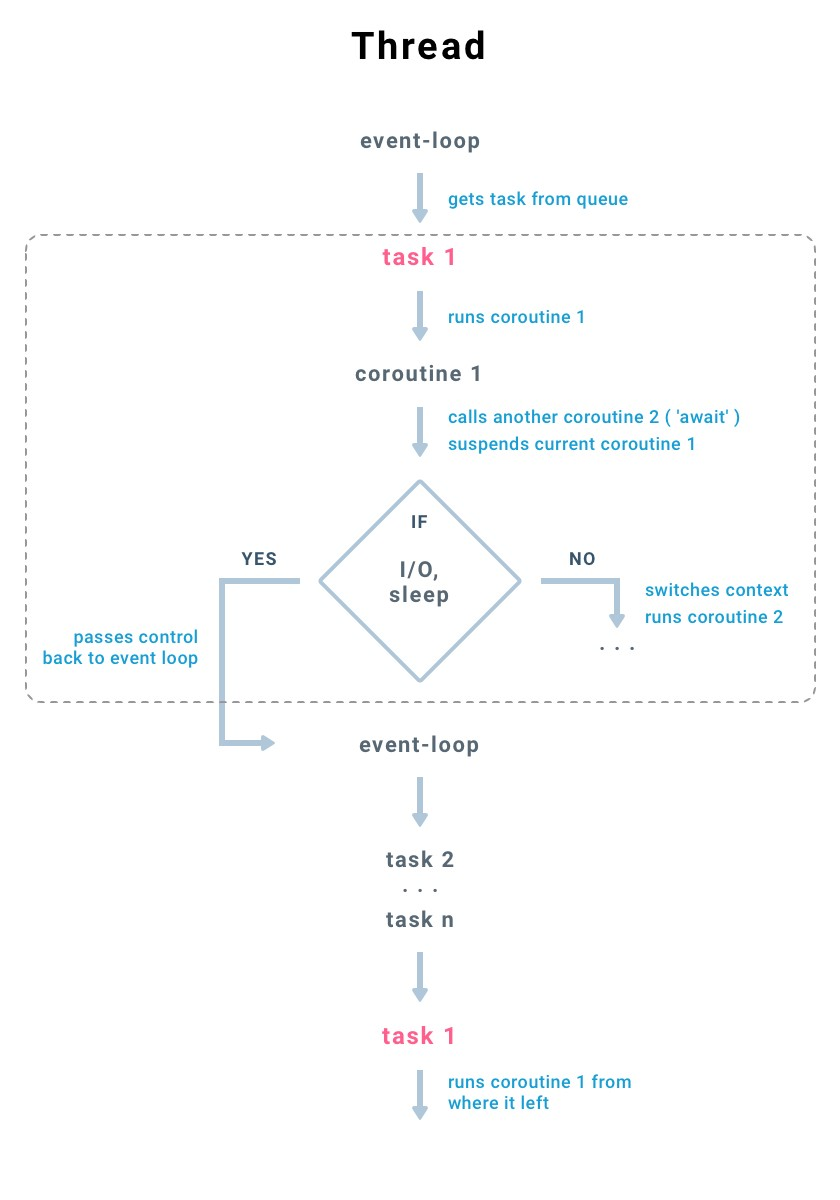

Event-loop существует в единственном числе в ОС треде, поэтому в каждый момент времени конкуретно может выполняться только один таск. Таски запускаются на event-loop в порядке FIFO очереди, возвращая контроль шедулеру в моменты выполнения I/O операций или явного прерывания.

Вся I/O функциональность event-loop построена вокруг блокирующего системного вызова `select`, который позволяет управлять ожиданием записи и чтения через сокеты. `select` по окончанию ожидания возвращает сокеты, получившие данные и готовые к чтению, и, соответственно,
освободившиеся сокеты, готовые к записи.

В момент прерывания исполнения перед I/O операцией происходит непосредственно следующее:

Предположим, в ходе исполнения корутины, происходит вызов операции чтения из сокета. Далее

1. Создается `asyncio.Future` объект (часть внутреннего API asyncio, представляющее собой отложенный результат выполнения асинхронной операции, который является промежуточным механизмом между низкоуровневым callback-based кодом, работающим с сокетами, и высокоуровневыми корутинами), привязанный к этому сокету. Вызвавшая операцию корутина прерывается на ожидании этого объекта.
2. Когда все текущие корутины в event-loop находятся в состоянии ожидания Future-объектов, вызывается `select.select` и текущий тред целиком блокируется.
3. `select.select` возвращает нужный сокет, готовый к операции чтения, данные записываются в буфер.
4. Вызывается `future.set_result()` на созданном `Future`.
5. Вызываются коллбэки `task.add_done_callback()` (корутины, исполняемые в event loop обернуты в `asyncio.Task`)
6. По цепочке вызовов вызыватся `send()` первоначальной корутины.
7. Данные читаются из буфера и возвращаются из `await` в корутину, продолжающую дальше свое выполнение.

## 6. Asyncio vs multithreading

Почему бы просто не использовать `concurrent.futures` для многопоточности и I/O, там же тоже есть все инструменты для работы с этим?

Потому что `asyncio` выполняет всю ту же самую работу используя единственный system thread, в то время, как порождение множества тредов займет гораздо больше времени как из-за более высокого потребления памяти, так и из-за переключений контекста между тредами.

In [ ]:
%%writefile test_asyncio.py
import asyncio
from random import gauss

async def task_generator(n: int):
    for _ in range(n):
        yield asyncio.sleep(gauss(0.01, 0.001))
        
async def asyncio_test(n):
    await asyncio.gather(*[t async for t in task_generator(n)])

def run_asyncio_test():
    import asyncio
    loop = asyncio.get_event_loop()
    loop.run_until_complete(asyncio_test(100000))

In [ ]:
from test_asyncio import run_asyncio_test

%mprun -f run_asyncio_test run_asyncio_test()

In [ ]:
%%script false

Filename: /Users/hyperboreus/study/python_lectures/edu_pres_images/test_asyncio.py

Line #    Mem usage    Increment   Line Contents
================================================
    11     27.7 MiB     27.7 MiB   def run_asyncio_test():
    12     27.7 MiB      0.0 MiB       import asyncio
    13     27.7 MiB      0.0 MiB       loop = asyncio.get_event_loop()
    14     56.4 MiB     28.7 MiB       loop.run_until_complete(asyncio_test(100000))

In [ ]:
%timeit run_asyncio_test()

In [ ]:
%%writefile test_threads.py

from random import gauss
from time import sleep
from concurrent.futures import ThreadPoolExecutor, wait

def threading_test(n):
    with ThreadPoolExecutor(max_workers=100) as executor:
        futures = [executor.submit(sleep, gauss(0.01, 0.001)) for _ in range(n)]
        wait(futures)

In [ ]:
from test_threads import threading_test

%mprun -f threading_test threading_test(100000)

In [ ]:
Filename: /Users/hyperboreus/study/python_lectures/edu_pres_images/test_threads.py

Line #    Mem usage    Increment   Line Contents
================================================
     6     64.3 MiB     64.3 MiB   def threading_test(n):
     7     64.3 MiB      0.0 MiB       with ThreadPoolExecutor(max_workers=100) as executor:
     8    250.3 MiB      0.7 MiB           futures = [executor.submit(sleep, gauss(0.01, 0.001)) for _ in range(n)]
     9    260.9 MiB     10.6 MiB           wait(futures)

In [ ]:
%timeit threading_test(100000)

## 8. Case-study: asynchronous crawler with aiohttp<a name="asyncio_use_cases"></a>

In [ ]:
#!/usr/bin/env python

# from https://github.com/mehmetkose/python3.5-async-crawler
# Licensed under the MIT license


import aiohttp
import asyncio
import async_timeout
from urllib.parse import urljoin, urldefrag
from itertools import zip_longest

headers = {'user-agent': 'Opera/9.80 (X11; Linux x86_64; U; en) Presto/2.2.15 Version/10.10'}
root_url = "http://python.org/"


crawled_urls = set()


def remove_fragment(url):
    pure_url, frag = urldefrag(url)
    return pure_url


def get_urls(html):
    new_urls = [url.split('"')[0] for url in str(html).replace("'",'"').split('href="')[1:]]
    return [urljoin(root_url, remove_fragment(new_url)) for new_url in new_urls]


async def get_body(url, session):
        try:
            async with async_timeout.timeout(10):
                async with session.get(url, headers=headers) as response:
                    if response.status == 200:
                        html = await response.text()
                        return None, html
                    else:
                        return response.status, None
        except Exception as err:
            return err, None


async def worker(work_queue, session):
    while not work_queue.empty():
        queue_url = await work_queue.get()
        if not queue_url in crawled_urls:
            crawled_urls.add(queue_url)
            err, body = await get_body(queue_url, session)
            if body:
                for new_url in get_urls(body):
                    if root_url in new_url and not new_url in crawled_urls:
                        work_queue.put_nowait(new_url)
            else:
                print(f"Error: {err} - {queue_url}")

In [ ]:
import nest_asyncio
import asyncio
nest_asyncio.apply()

async def size_printer(q):
    await asyncio.sleep(30)
    print(f"urls visited {len(crawled_urls)} queue size {q.qsize()}")

root_url = "http://python.org/"

q = asyncio.Queue() #  Просто FIFO очередь, put и get которой являются асинхронными операциями
q.put_nowait(root_url)

loop = asyncio.get_event_loop() # получили текущий инстанс event-loop
session = aiohttp.ClientSession() # создали HTTP-сессию


asyncio.create_task(size_printer(q))  # Запустили мониторящий таск в фоновом режиме
loop.run_until_complete(worker(q, session))  # Синхронный метод, который передает контроль непосредственно коду, запускающему
# циклы event-loop в данном треде.
loop.run_until_complete(session.close())

# Безопасное завершение работы
tasks = asyncio.Task.all_tasks()
for t in tasks:
    t.cancel()  # Передает CancelException в каждый таск, чтобы завершить его работу
group = gather(*tasks, return_exceptions=True)
loop.run_until_complete(group)  # Теперь точно знаем, что никаких незавершенных тасков не осталось. Можно завершить работу.
loop.close()

Хорошо, понятно, просто. Но медленно. Работает не быстрее чем пул тредов с очередью из-за явного `await get_body` в коде воркера, прерывающего его исполнение. Можем добавить больше воркеров, но сильно быстрее не станет.

Как сделать так, чтобы очереди и явных ожиданий не было, а как можно больше независимых тасков, выполняющих запросы, работали в фоновом режиме?

Вот так:

In [ ]:
# Слегка переделанный пример из https://github.com/aio-libs/aiohttp/blob/master/examples/legacy/crawl.py
import nest_asyncio
nest_asyncio.apply()
import asyncio
import logging
import re
import signal
import sys
import urllib.parse

import aiohttp


class Crawler:

    def __init__(self, rooturl, maxtasks=100):
        self.rooturl = rooturl
        self.todo = set()
        self.busy = set()
        self.done = {}
        self.tasks = set()
        self.sem = asyncio.Semaphore(maxtasks)

        # connector stores cookies between requests and uses connection pool
        self.session = aiohttp.ClientSession()

    async def run(self):
        task = asyncio.create_task(self.addurls([(self.rooturl, '')]))
        await asyncio.sleep(1)
        while self.busy:
            await asyncio.sleep(1)
            print(f"done size {len(self.done)} todo size {len(self.todo)}")

        await task
        await self.session.close()

    async def addurls(self, urls):
        for url, parenturl in urls:
            url = urllib.parse.urljoin(parenturl, url)
            url, frag = urllib.parse.urldefrag(url)
            if (url.startswith(self.rooturl) and
                    url not in self.busy and
                    url not in self.done and
                    url not in self.todo):
                self.todo.add(url)
                await self.sem.acquire()
                task = asyncio.create_task(self.process(url))
                task.add_done_callback(lambda t: self.sem.release())
                task.add_done_callback(self.tasks.remove)
                self.tasks.add(task)

    async def process(self, url):
        self.todo.remove(url)
        self.busy.add(url)
        try:
            resp = await self.session.get(url)
        except Exception as exc:
            print('...', url, 'has error', repr(str(exc)))
            self.done[url] = False
        else:
            if (resp.status == 200 and
                    ('text/html' in resp.headers.get('content-type'))):
                data = (await resp.read()).decode('utf-8', 'replace')
                urls = re.findall(r'(?i)href=["\']?([^\s"\'<>]+)', data)
                asyncio.Task(self.addurls([(u, url) for u in urls]))

            resp.close()
            self.done[url] = True

        self.busy.remove(url)


def main():
    loop = asyncio.get_event_loop()

    c = Crawler("http://python.org/")
    asyncio.create_task(c.run())

    try:
        loop.add_signal_handler(signal.SIGINT, loop.stop)
    except RuntimeError:
        pass
    loop.run_forever()
    
main()

## 8. Conclusion: asyncio use-cases and benefits<a name="asyncio_use_cases"></a>

### Веб-сервисы. 

Выбор фреймворка для веб-приложения в самом первом приближении может быть обусловлен планируемой нагрузкой или простотой разработки. Популярные синхронные фреймворки e.g. `Django` могут давать очень много готового функционала "из коробки". В случае `Django` - это готовая админка, ORM, огромное количество готовых экстеншенов. Порядок отличий по планируемой нагрузке можно видеть из приведенных бенчмарков. 

Измеряется время запрос-ответ с чтением из БД (`Postgres`). 

#### Requests per second
<img src="https://lh3.googleusercontent.com/VzWDXfSTGs6aCBLnFpKMN_U4GLrSlI7L85dFzkzHLkQhn60Pnw7a6ag7mjG2wboujv-ypTWLRVIAQPIOxa2zEOEQM1WsDDG6-jIPFEXVT4jGt9YOghdFLLP9RzWT2xa7HgxvzdvR" height="600" width="600"/>

#### Avg. response time (ms)
<img src="https://lh5.googleusercontent.com/4zCCmLzCIkHQnwqQf7XxdT21ZUqZ9Nol-XjcXgmYYnpvtZcRTO65RqaI5_loJZqPB6uk9wBc3JGKJNWNjYqcPI6l5IN-xAT3bWvAKWCtyW8BgoNLn73tsFtAkHCx-X9wRIUSZEfa" height="600" width="600">

<a href="https://blog.startmatter.com/top-fast-python-web-frameworks-in-2019/"> Оригинал здесь </a>

#### Масштабируемость.

Asyncio легко масштабируется с помощью load balancer-а и запуска нескольких параллельных процессов, в кажном из которых свой event-loop.

#### Приложения с большим количеством короткоживущих тредов.

Даже если это большой UI, где в тредах находятся смешанные I/O и CPU задачи, но структура их многопоточности такова, что тредов много и большая часть из них - короткоживущие, можно попробовать использовать `asyncio` (если конечно не очень дорого все это переписывать), чтобы улучшить потребление ресурсов и тратить меньше памяти.

#### Серверные приложения, которые делают большое количество сетевых вызовов 

e.g. краулеры - будут работать значительно быстрее и тратить меньше ресурсов.

#### Разработка и поддержка проще чем с multithreading

На выбор `asyncio` может также повлиять то, что разработка на нем дает гораздо более чистый код, чем работа с тредами. В `asyncio` мы явно приостанавливаем выполнение с помощью `await` и работать с shared memory гораздо проще чем при мультитрединге, где для этого придется использовать примитивы синхронизации. 

<center><h1> Спасибо! </h1></center>

<img src="https://media.giphy.com/media/YmVNzDnboB0RQEpmLr/giphy.gif"/>

<center><h1> Вопросы? </h1></center>

## Найти материалы на гитхабе:
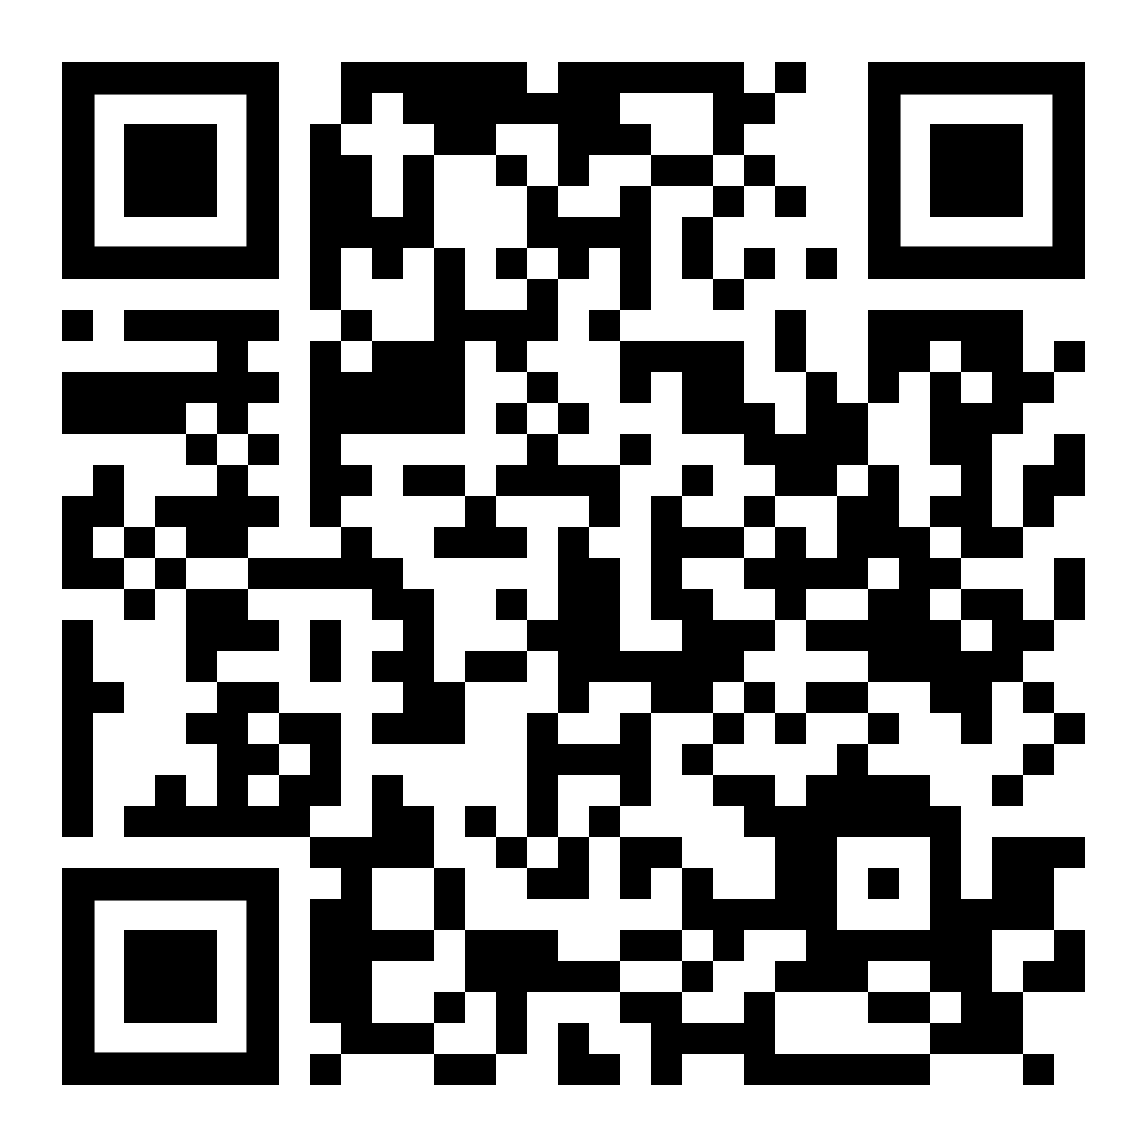